## Part 1. Importing libraries and downloading the dataset and pre-trained weights

In [2]:
!pip install torch torchvision

In [3]:
import argparse
import os
import random

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time

try:
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
except:
    pass

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [5]:
!pip install onedrivedownloader

In [6]:
from onedrivedownloader import download

link1 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/jukmaatt_univ_yo_oulu_fi/EXSonItiHilPoo2WequIRCIBr-RdQDTH2xWvmpjbdGisxQ?e=4QbKCv'

link2 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/jukmaatt_univ_yo_oulu_fi/EUvPUbTJW4NNiyc5Nmdf_C0ByyC6eAPf7BdRW_lQE-WDQw?e=lTrBx0'

if not os.path.exists('./data_hw4/anime'):
    print('Downloading the AnimeFace dataset')
    download(link1, filename='./anime.zip', unzip=True, unzip_path='./data_hw4/anime')

if not os.path.exists('./pretrained'):
    print('Downloading pre-trained weights')
    download(link2, filename='./gan_pretrained.zip', unzip=True, unzip_path='./pretrained')

## Part 2. Build my own GAN

A [**Generative Adversarial Network (GAN)**](https://en.wikipedia.org/wiki/Generative_adversarial_network) consists of two parts:

* The **generator** learns to generate plausible data. The generated instances become negative training examples for the discriminator.

* The **discriminator** learns to distinguish real samples from the fake data created by the generator. The discriminator penalizes the generator for not being able to produce credible outputs.

At the beginning of the training process, the generator produces evidently fake samples, thus the discriminator learns quickly to tell that they are fake. As training progresses, the generator starts to become capable of producing outputs that may fool the discriminator.

In the following parts, I will build a simple generator and discriminator based on [DCGAN (Deep Convolutional Generative Adversarial Network)](https://arxiv.org/abs/1511.06434) by Radford et al.

GANs have been known to be unstable to train, often resulting in generators that produce nonsensical outputs. To achieve stable deep convolutional GANs, Radford et al. proposed the following main architecture guidelines and common changes to typical convolutional neural networks (CNNs):
* Replace any pooling layers with strided convolutions in discriminator and fractional-strided convolutions (also known as deconvolution or transposed convolutions) in generator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh, as using a bounded activation allows the model to learn more quickly to saturate and cover the color space of the training distribution.
* Use LeakyReLU activation in the discriminator for all layers.
* Use batch normalization in both the generator and the discriminator, except for the generator output layer and the discriminator input layer, which may result in sample oscillation and model instability.

### Build the generator

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Shapes of each layer: inputs -> outputs, (B, C, H, W)

        # conv1: (B, 100, 1, 1) -> (B, 128, 4, 4)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )

        # conv2: (B, 32, 16, 16) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )

        # conv3: (B, 64, 8, 8) -> (B, 128, 4, 4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # conv3: (B, 128, 4, 4) -> (B, 1, 1, 1)
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU()
        )

        # conv4: (B, 32, 16, 16) -> (B, 3, 32, 32)
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [11]:
# Create the generator
model_G = Generator().to(device)
print(model_G, '\n')

B = 2
noises = torch.randn((B, 100, 1, 1), device=device)
images = model_G(noises) # It will call the `forward()` function when using `model_G()`.

print('Shape of input:', noises.shape)
print('Shape of output:', images.shape)

Generator(
  (conv1): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
) 

Shape of input: torch.Size([2, 100, 1, 1])
Shape of output: torch.Size([2, 3, 32, 32])


### Build the discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # Shapes of each layer: inputs -> outputs, (B, C, H, W)

        # conv1: (B, 3, 32, 32) -> (B, 32, 16, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # conv2: (B, 32, 16, 16) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # conv3: (B, 64, 8, 8) -> (B, 128, 4, 4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # conv3: (B, 128, 4, 4) -> (B, 1, 1, 1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.flatten()
        return x

In [14]:
# Create the discriminator
model_D = Discriminator().to(device)
print(model_D, '\n')

B = 2
images = torch.randn((B, 3, 32, 32), device=device)
outputs = model_D(images) # It will call the `forward()` function when using `model_D()`.

print('Shape of input:', images.shape)
print('Shape of output:', outputs.shape)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
) 

Shape of input: torch.Size([2, 3, 32, 32])
Shape of output: torch.Size([2])


In [15]:
### Load pre-trained weights

In [18]:
def load_pretrained_weights(model_G, model_D, device, is_debug=False):
    weights_G_path = 'pretrained/weights_G.pth'
    weights_D_path = 'pretrained/weights_D.pth'

    # Load weights with weights_only=True for safety
    weights_G = torch.load(weights_G_path, map_location=device, weights_only=True)
    weights_D = torch.load(weights_D_path, map_location=device, weights_only=True)

    # Load weights into the models
    model_G.load_state_dict(weights_G)
    model_D.load_state_dict(weights_D)

    # Debug information
    if is_debug:
        print('The type of weights_D:\n', type(weights_D), '\n')
        print('The keys in weights_D:\n', list(weights_D.keys()), '\n')
        print('The shape of conv1.0 in weights_D:\n', weights_D['conv1.0.weight'].shape)

model_G = Generator().to(device)
model_D = Discriminator().to(device)

load_pretrained_weights(model_G, model_D, device, is_debug=True)

The type of weights_D:
 <class 'collections.OrderedDict'> 

The keys in weights_D:
 ['conv1.0.weight', 'conv2.0.weight', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'conv4.0.weight'] 

The shape of conv1.0 in weights_D:
 torch.Size([32, 3, 4, 4])


From the above outputs, we can also notice that the pretrained weights are stored as a `dict`. Its keys contain the name of each layer, and the weights are saved as tensors directly. Next, I will make a visual comparison between the outputs of the randomly initialized and pre-trained generators.

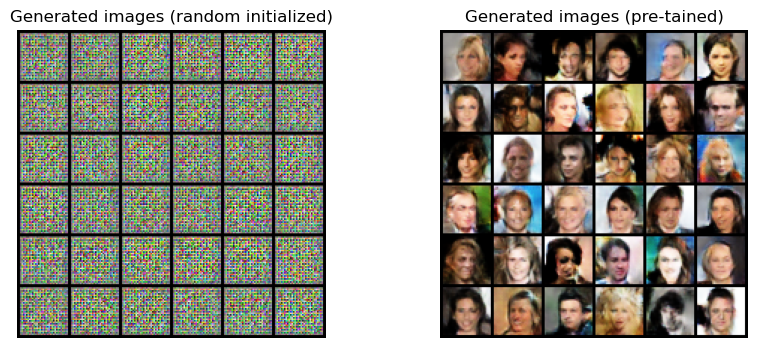

In [21]:
ig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Create the instances of Generator and Discriminator
model_G = Generator().to(device)
model_D = Discriminator().to(device)

# Create a set of fixed noise vectors for visualization
fixed_noise = torch.randn((36, 100, 1, 1), device=device)

# Generate images with the random initialized Generator and display them
generated_images = model_G(fixed_noise)
generated_images = utils.make_grid(generated_images.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[0].axis('off')
ax[0].set_title('Generated images (random initialized)')
ax[0].imshow(np.transpose(generated_images, (1, 2, 0)))

# Load the pre-trained weights for the Generator and Discriminator
load_pretrained_weights(model_G, model_D, device)

# Generate images with the pre-trained Generator and display them
generated_images_pretrained = model_G(fixed_noise)
generated_images_pretrained = utils.make_grid(generated_images_pretrained.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[1].axis('off')
ax[1].set_title('Generated images (pre-tained)')
ax[1].imshow(np.transpose(generated_images_pretrained, (1, 2, 0)))

## Part 3. Retrain the pre-trained GAN on a new dataset

### 3.1 Preparing the dataset and dataloader

In [30]:
'''
Hyperparameters
'''
image_size = 32

# Batch size for training
batch_size = 128
num_workers = 1

# Learning rate for optimizers
lr = 0.0002

# Number of training epochs
num_epochs = 30

Then, let's create the dataset and dataloader to load the AnimeFace dataset for training.

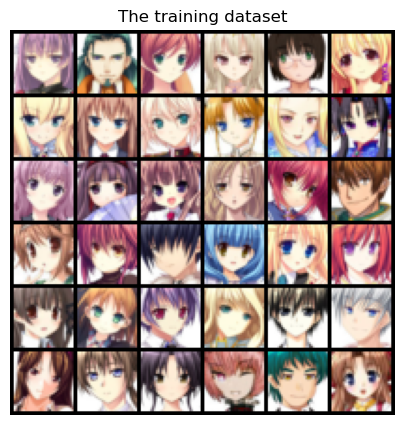

In [33]:
# I can use the ImageFolder class due to the structure of the AnimeFace dataset
# Create the dataset
dataset = torchvision.datasets.ImageFolder(
    root='./data_hw4',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The training dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))

Finally, I integrate all the model definition and initialization steps into one function `init_model_and_optimizer()`.

I choose binary cross entropy ([`nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)) as the loss function because we are dealing with a binary classification problem.

In [36]:
def init_model_and_optimizer():

    # Create the instances of Generator and Discriminator
    model_G = Generator().to(device)
    model_D = Discriminator().to(device)

    # Load the pre-trained weights for model_G and model_D
    load_pretrained_weights(model_G, model_D, device)

    # Setup Adam optimizers for both model_G and model_D
    optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(0.5, 0.999))

    # Initialize the loss function for training
    BCE_loss = nn.BCELoss()

    return model_G, model_D, optimizer_G, optimizer_D, BCE_loss

In [38]:
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

### 3.2 Training step for the discriminator

The training data for the discriminator comes from two sources:
- Real images, such as real pictures of faces: The discriminator uses these instances as positive examples during training.
- Fake images generated by the generator: The discriminator uses these instances as negative examples during training.

During the training step:
- The discriminator classifies both **real images and fake images** from the generator.
- The discriminator loss penalizes the discriminator for misclassifying a real instance as fake or a fake instance as real.
- The discriminator updates its weights through backpropagation from the discriminator loss through the discriminator network.

In [44]:
def training_step_D(
    real_images,
    model_G: nn.Module,
    model_D: nn.Module,
    optimizer_D: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Discriminator.

    Args:
        real_images: a batch of real image data from the training dataset
        model_G: the generator model
        model_D: the discriminator model
        optimizer_D: optimizer of the Discriminator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_D: the discriminator loss

    """

    # Reset the gradients of all parameters in discriminator
    model_D.zero_grad()

    batch_size = real_images.shape[0]

    # Prepare the real images and their labels
    real_images = real_images.to(device)
    real_labels = torch.ones((batch_size, ), device=device)

    # Prepare the fake images and their labels using the generator and the random `noise` created below
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)
    fake_labels = torch.zeros((batch_size,), device=device)

    # Call `model_D()` and `BCE_loss` to calculate the losses for real and fake images
    real_outputs = model_D(real_images)
    loss_D_real = BCE_loss(real_outputs, real_labels)

    fake_outputs = model_D(fake_images.detach())
    loss_D_fake = BCE_loss(fake_outputs, fake_labels)


    # Sum the loss of both real images and fake images to get the total discriminator loss
    loss_D = loss_D_real + loss_D_fake

    # Compute the gradients
    loss_D.backward()

    # Update the parameters of `model_D`
    optimizer_D.step()

    if is_debug:
        print('Shape of real outputs:\n', real_outputs.shape, '\n')
        print('Shape and samples of real labels:\n', real_labels.shape, ' ', real_labels[:5], '\n')

        print('Shape of fake outputs:\n', fake_outputs.shape, '\n')
        print('Shape and samples of fake labels:\n', fake_labels.shape, ' ', fake_labels[:5], '\n')

    return loss_D

In [46]:
batch_data = torch.randn((batch_size, 3, 32, 32), device=device)
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_D = training_step_D(batch_data, model_G, model_D, optimizer_D, BCE_loss, is_debug=True)
print('Discriminator loss:\n', loss_D)

Shape of real outputs:
 torch.Size([128]) 

Shape and samples of real labels:
 torch.Size([128])   tensor([1., 1., 1., 1., 1.]) 

Shape of fake outputs:
 torch.Size([128]) 

Shape and samples of fake labels:
 torch.Size([128])   tensor([0., 0., 0., 0., 0.]) 

Discriminator loss:
 tensor(11.4299, grad_fn=<AddBackward0>)


### 3.3 Implement the training step for the generator

The training process for the generator requires tighter integration between the generator and the discriminator compared with the training step for the discriminator. The portion of the GAN that trains the generator includes:
- Random noise as input
- The generator network for transforming the random input into a data instance
- The discriminator network for classifying the generated data and its output
- Generator loss for penalizing the generator for failing to fool the discriminator

To train a neural net, we typically alter the model weights to reduce the error (loss). In my GAN, however, the generator is not directly connected to the loss that we're trying to affect. The generator feeds into the discriminator net, and the discriminator produces the output we're trying to affect. 

**The generator loss penalizes the generator for producing an image that the discriminator network classifies as fake. In other words, I wish the generated images could be classified as real by the discriminator in this training step.**

In [50]:
def training_step_G(
    model_G: nn.Module,
    model_D: nn.Module,
    optimizer_G: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Generator.

    Args:
        model_G: the generator model
        model_D: the discriminator model
        optimizer_G: optimizer for the generator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_G: the generator loss

    """

    # Reset the gradients of all parameters in `model_G`
    model_G.zero_grad()

    # Generate fake images from `model_G` with random noises
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)


    # Prepare labels for fake_images
    labels = torch.ones((batch_size, ), device=device)


    # Call `model_D()` and `BCE_loss` to calculate the loss of Generator
    outputs = model_D(fake_images)
    loss_G = BCE_loss(outputs, labels)


    # Compute the gradients
    loss_G.backward()

    # Update the parameters of `model_G`
    optimizer_G.step()

    if is_debug:
        print('Shape of outputs:\n', outputs.shape, '\n')
        print('Shape of labels:\n', labels.shape, '\n')

    return loss_G

In [52]:
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss, is_debug=True)

Shape of outputs:
 torch.Size([128]) 

Shape of labels:
 torch.Size([128]) 



### 3.4 Train and evaluate your GAN

In [54]:
# Create the model, optimizer, and loss funtions for training

model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()


# Lists and variables to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

torch.random.seed()
start_time = time.time()


# Training Loop

print("Starting the training loop...")

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (real_images, _) in enumerate(dataloader, 0):

        # Call the `training_step_D()` and `training_step_G()` and collect the loss values `loss_D` and `loss_G`
        loss_D = training_step_D(real_images, model_G, model_D, optimizer_D, BCE_loss)
        loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss)

        # Output training stats
        if i % 50 == 0:
            print('[Epoch][Iter][{}/{}][{}/{}] Loss_D: {:.4f}, Loss_G: {:.4f}, Time: {:.2f} s'.format(
                epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), time.time() - start_time))
            start_time = time.time()

        # Save losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = model_G(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True, nrow=6))
        iters += 1

print("Training finished!")

Starting the training loop...
[Epoch][Iter][0/30][0/16] Loss_D: 1.9879, Loss_G: 0.9080, Time: 4.10 s
[Epoch][Iter][1/30][0/16] Loss_D: 0.0605, Loss_G: 4.1186, Time: 15.59 s
[Epoch][Iter][2/30][0/16] Loss_D: 0.1088, Loss_G: 3.6310, Time: 5.89 s
[Epoch][Iter][3/30][0/16] Loss_D: 0.1154, Loss_G: 4.3512, Time: 6.05 s
[Epoch][Iter][4/30][0/16] Loss_D: 0.1579, Loss_G: 4.0823, Time: 5.79 s
[Epoch][Iter][5/30][0/16] Loss_D: 0.8142, Loss_G: 8.0609, Time: 5.72 s
[Epoch][Iter][6/30][0/16] Loss_D: 0.2704, Loss_G: 4.0555, Time: 5.82 s
[Epoch][Iter][7/30][0/16] Loss_D: 1.0924, Loss_G: 0.7681, Time: 5.87 s
[Epoch][Iter][8/30][0/16] Loss_D: 0.4336, Loss_G: 2.9833, Time: 5.70 s
[Epoch][Iter][9/30][0/16] Loss_D: 0.3671, Loss_G: 2.6727, Time: 5.92 s
[Epoch][Iter][10/30][0/16] Loss_D: 0.4131, Loss_G: 2.2488, Time: 5.65 s
[Epoch][Iter][11/30][0/16] Loss_D: 0.4129, Loss_G: 3.8199, Time: 5.83 s
[Epoch][Iter][12/30][0/16] Loss_D: 1.1797, Loss_G: 7.8536, Time: 5.86 s
[Epoch][Iter][13/30][0/16] Loss_D: 0.4485, 

Let's plot the generator and discriminator losses during training our GAN.

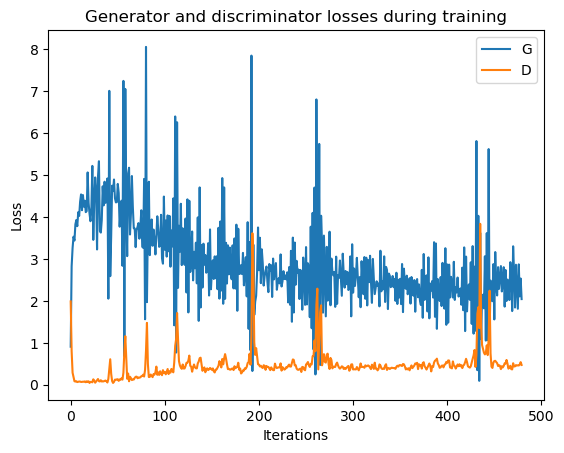

In [56]:
plt.figure()
plt.title("Generator and discriminator losses during training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Let's inspect how the generated images look like after the training of our GAN has finished.

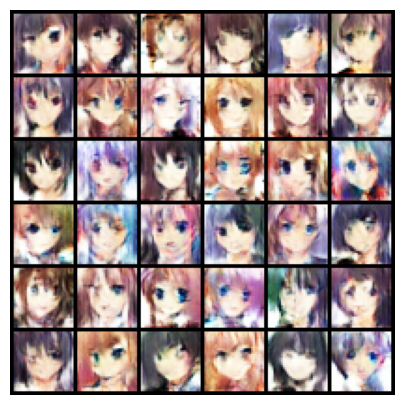

In [57]:
fig = plt.figure(figsize=(5, 5))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

I can also visualize how the quality of the generated images changes during training.

In [59]:
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())